In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as geo
from mortgage import Loan 
import requests
import irr
import calendar
import math
import sqlite3
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
con = sqlite3.connect(r"C:\Users\Pavan\OneDrive\Desktop\HMDAData.db")

In [4]:
cur = con.cursor()

In [5]:
query='''SELECT DISTINCT("derived_msa-md") 
        FROM cleaned_2018'''
msas=pd.read_sql_query(query, con)["derived_msa-md"]
len(msas)

403

In [6]:
house=pd.read_csv("house.csv")
deep=pd.read_csv("deep.csv")
mo= pd.read_csv("mo.csv")
hr= pd.read_csv("hr.csv")
names= pd.read_csv("names.csv")
census= pd.read_csv("census")
go=pd.read_csv("go.csv")
g_fee=pd.read_csv("gfee.csv")
av=pd.read_csv("avg_credit.csv")

In [7]:
import pickle
pkl_filename = "credit_model.pkl"
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [8]:
g_fee.index=g_fee["credit"]

In [9]:
g_fee=g_fee.drop("credit",axis=1)

In [10]:
deep["fips"]=deep["fips"].astype(str)

In [11]:
hr["id"]=hr["id"].astype(str)
house["id"]=house["id"].astype(str)
mo["id"]=mo["id"].astype(str)
#cont=self.one["county_code"].unique()
names["FIPS"]=names["FIPS"].astype(str)

In [12]:
l=[]
for i in names["FIPS"]: 
        if len(i)<5: 
            l.append("0"+i)
        else: 
            l.append(i)
names["FIPS"]=l

In [13]:
mo["id"]=["0"+i for i in mo["id"]]

In [14]:
hr["id"]=["0"+i for i in hr["id"]]

In [15]:
house["id"]=["0"+i for i in house["id"]]

In [16]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))


In [110]:
class Results:
    errors=[]
    def __init__(self,MSA):
        self.MSA=MSA
        self.one=pd.DataFrame()
        self.error=0
        self.error1=0
        self.asian_combined_solar=0
        self.black_combined_solar=0
        self.hispanic_combined_solar=0
        self.white_maj=0
        self.asian_maj=0
        self.black_maj=0
        self.v=pd.DataFrame()
        self.hispanic_maj=0
    def get_data_2018(self):
        query=''' SELECT * FROM cleaned_2018 Where "derived_msa-md"='''+"'" + self.MSA + "'"
        self.one=pd.read_sql_query(query, con)
        
    def final_cleaning(self): 
        v=self.one.groupby("lei").size().sort_values(ascending=False)
        v=v[16:]
        v=v[v>10].index
        v=pd.DataFrame(v)
        self.v=v
        self.one=self.one[self.one["rate_spread"]!="Exempt"].reset_index().drop("index",axis=1)
        self.one=self.one[self.one["county_code"]!="NA"].reset_index().drop("index",axis=1)
        self.one=self.one.merge(v)
        self.one=self.one[self.one["debt_to_income_ratio"]!=">60%"].reset_index().drop("index",axis=1)
        self.one=self.one[self.one["origination_charges"]!="NA"].reset_index().drop("index",axis=1)
        self.one["origination_charges"]=self.one["origination_charges"].astype(float)
        self.one["discount_points"]=self.one["discount_points"].replace({'':"0"})
        self.one["lender_credits"]=self.one["lender_credits"].replace({'':"0"})
        self.one["discount_points"]=self.one["discount_points"].astype(float)
        self.one=self.one[self.one["loan_to_value_ratio"]!="NA"]
        self.one=self.one[self.one["property_value"]!="NA"]
        self.one["loan_amount"]=self.one["loan_amount"].astype(float)
        self.one["income"]=self.one["income"].astype(float)
        self.one["property_value"]=self.one["property_value"].astype(float)
        self.one["tract_to_msa_income_percentage"]=self.one["tract_to_msa_income_percentage"].astype(float)
        self.one["loan_to_value_ratio"]=self.one["loan_to_value_ratio"].astype(float)
        self.one["rate_spread"]=self.one["rate_spread"].astype(float)
        self.one["interest_rate"]=self.one["interest_rate"].astype(float)
        self.one= self.one[self.one['applicant_age']!="9999"]
        self.one=self.one[(self.one["purchaser_type"]=="Fannie Mae")|(self.one["purchaser_type"]=="Freddie Mac")].reset_index().drop("index",axis=1)
        self.one=self.one[self.one["loan_term"]=="360"].reset_index().drop("index",axis=1)
        self.one=self.one[self.one["intro_rate_period"]=="NA"].reset_index().drop("index",axis=1)
        self.one=self.one[self.one["loan_amount"]>30000].reset_index().drop("index",axis=1)
        self.one=self.one[(self.one["loan_to_value_ratio"]>30) &(self.one["loan_to_value_ratio"]<130)].reset_index().drop("index",axis=1)
        self.one=self.one[(self.one["income"]!=1) &(self.one["income"]!=9999)].reset_index().drop("index",axis=1)
        self.one["cost"]=self.one["Cost_of_Loan"].astype(float)+self.one["discount_points"].astype(float)-self.one["lender_credits"].astype(float)
        assert self.one.shape[0]>100
        try: 
            self.one["bin_lv"]=pd.qcut(self.one['loan_to_value_ratio'], 4,labels=["below 25th percentile","between 25th percentile and 50th percentile","between 50th percentile and 75th percentile","greater than 75th percentile"])
        except: 
            self.one["bin_lv"]=pd.qcut(self.one['loan_to_value_ratio']+ jitter(self.one['loan_to_value_ratio']), 4,labels=["below 25th percentile","between 25th percentile and 50th percentile","between 50th percentile and 75th percentile","greater than 75th percentile"])
        self.one["interest_rate"]=self.one["interest_rate"].astype(float)
        self.one["interest_basis_points"]=self.one["interest_rate"]*100
        self.one["lender_credits"]=self.one["lender_credits"].astype(float)
        self.one["discount"]= self.one["discount_points"]-self.one["lender_credits"]
        self.one["discount"]=self.one["discount"]/self.one["loan_amount"]*1*100
        self.one["origination_charges"]= self.one["origination_charges"]/self.one["loan_amount"]*1*100
        assert self.one.shape[0]>100
    def date(self):
        
        pigo=go.pivot(columns="month", values="30").fillna(-1)
        def get_date(i): 
            l=[self.one["interest_rate"][i],self.one["loan_amount"][i],self.one["property_value"][i],self.one["cost"][i],self.one["loan_term"][i]]
            loan=Loan(principal=l[1], interest=float(l[0])/100, term=30)
            mon=float(loan.monthly_payment)
            x=[-l[1]+l[3]]+(np.ones(360)*mon).tolist()
            v=irr.irr_newton(x)*12*100
            r=v-self.one["rate_spread"][i]
            r1=round(r,1)
            
            r2=round(r,2)
            m=go.where(go["t"]==r1).dropna()["month"].reset_index()["month"].unique()
            y=[]
            for i in m: 
                x=min(abs(r2-pigo[i]))
                y.append(x)
            return m[y.index(min(y))]
        f=[]
        error=[]
        for i in range(len(self.one)): 
            try: 
                f.append(get_date(i))
            except: 
                error.append(i)
                #print(i)
                
        Results.errors.append(len(error)/len(self.one))
        self.one=self.one.drop(error)
        self.one["est_month"]= f
    def g_fee(self): 
        av.index= av["MSA"]
        g_fee.astype
        def md_MSA(md): 
            if (md==14484) |(md==15764)|(md==37764)|(md==40484):
                return 14460
            elif (md==16974) |(md==23844)|(md==29404): 
                return 16980
            elif (md==19124) |(md==23104): 
                return 19100
            elif (md==19804) |(md==47644):
                return 19820
            elif (md==31084) |(md==42044): 
                return 31100
            elif (md==22744) |(md==33124)|(md==48424):
                return 33100
            elif (md==20764) |(md==35004)|(md==35084)|(md==35644): 
                return 35620
            elif (md==15804) |(md==37964)|(md==48864):
                return 37980
            elif (md==36084) |(md==41884):
                return 41860 
            elif (md==42644) |(md==45104): 
                return 42660 
            elif (md==13644) |(md==47894): 
                return 47900
        try: 
            self.one["av_credit"]=av["credit_score"][int(self.MSA)]
        except: 
            self.one["av_credit"]=av["credit_score"][md_MSA(int(self.MSA))]
        cr=self.one[["bin_lv","total_units","debt_to_income_ratio","av_credit"]]
        X=pd.get_dummies(cr[["bin_lv","debt_to_income_ratio","total_units"]])
        r=["debt_to_income_ratio_30%-<36%",'debt_to_income_ratio_36%-<41%','debt_to_income_ratio_41%-<46%','debt_to_income_ratio_46%-<50%','debt_to_income_ratio_50%-60%','debt_to_income_ratio_<20%','total_units_1','total_units_2','total_units_3','total_units_4']
        try: 
            assert len(X)==16
        except: 
            for i in r: 
                if i not in X.columns: 
                    X[i]=0
        
        X["av_credit"]= cr["av_credit"]
        self.error= X
        predict=pickle_model.predict(X)
        self.one["predicted_credit_score"]=predict
        self.one=self.one.reset_index()
        l=[]
        for i in self.one['loan_to_value_ratio']: 
            i=round(i)
            if i<=60: 
                l.append(g_fee.columns[0])
            elif i>= 60.01 and i<=70: 
                l.append(g_fee.columns[1])
            elif i>= 70.01 and i<=75: 
                l.append(g_fee.columns[2])
            elif i>= 75.01 and i<=80: 
                l.append(g_fee.columns[3])
            elif i>= 80.01 and i<=85: 
                l.append(g_fee.columns[4])
            elif i>= 85.01 and i<=90: 
                l.append(g_fee.columns[5])
            elif i>= 90.01 and i<=95: 
                l.append(g_fee.columns[6])
            elif i>= 95.01 and i<=97: 
                l.append(g_fee.columns[7])
            elif i>97: 
                l.append(g_fee.columns[8])
        self.one["gltv"]= l
        l=[]
        for i in self.one['predicted_credit_score']: 
            i=round(i)
            if i<620: 
                l.append(g_fee.index[-1])
            elif i>= 620 and i<=639: 
                l.append(g_fee.index[-2])
            elif i>= 640 and i<=659: 
                l.append(g_fee.index[-3])
            elif i>= 660 and i<=679: 
                l.append(g_fee.index[-4])
            elif i>= 680 and i<=699: 
                l.append(g_fee.index[-5])
            elif i>= 700 and i<=719: 
                l.append(g_fee.index[-6])
            elif i>= 720 and i<=739: 
                l.append(g_fee.index[-7])
            elif i>= 740: 
                l.append(g_fee.index[-8])
        self.one["cltv"]= l
        self.one=self.one.reset_index().drop("index",axis=1)
        g=[]
        for i in range(len(self.one)): 
            cred=self.one["cltv"][i]
            ltv=self.one["gltv"][i]
            t=self.one["total_units"][i]
            k=g_fee[ltv][cred]
            
            if t=="1": 
                g.append(k)
            else: 
                g.append(float(k)+1)
        self.one["g_fee"]=g
        self.one["g_basis"]=100*self.one["g_fee"]
    def get_solar(self):
        hr["id"]=hr["id"].astype(str)
        house["id"]=house["id"].astype(str)
        mo["id"]=mo["id"].astype(str)
        cont=self.one["county_code"].unique()
        names["FIPS"]=names["FIPS"].astype(str)
        cont=[i for i in cont if sum(names["FIPS"]==i)==1]
        #names["FIPS"]=["0"+i for i in names["FIPS"]]
        nc=[names[names["FIPS"]==i]["county"].reset_index()["county"][0] for i in cont]
        nc=pd.Series(nc).str.replace(' ', '')
        filtered=pd.DataFrame()
        for i in nc: 
            filtered=pd.concat([deep[deep["county"]==i],filtered])
        filtered=filtered.reset_index().drop(["index","Unnamed: 0"],axis=1)
        filtered["fips"]=filtered["fips"].astype(str)
        filtered["fips"]=["0"+i for i in filtered["fips"]]
        self.error1=filtered
        try: 
            filtered=filtered.merge(census, left_on="fips",right_on="id")
            assert filtered.shape[0]!=0 
        except: 
            self.error1["fp"]=self.error1["fips"].str.slice(start=1)
            filtered=self.error1.merge(census, left_on="fp",right_on="id")
        self.error=filtered
        filtered["Asian%_tract"]=filtered["Asian%_tract"].astype(float)
        filtered["Black or African American%_tract"]=filtered["Black or African American%_tract"].astype(float)
        filtered["Hispanic or Latino (of any race)%_tract"]=filtered["Hispanic or Latino (of any race)%_tract"].astype(float)
        filtered["White%_tract"]=filtered["White%_tract"].astype(float)
        l=[]
        for i in range(len(filtered)):
            asian= filtered["Asian%_tract"][i]
            black= filtered["Black or African American%_tract"][i]
            hispanic= filtered["Hispanic or Latino (of any race)%_tract"][i]
            white= filtered["White%_tract"][i]
            x=np.array([asian,black,white,hispanic])
            sor=np.argsort(x)
            first=sor[-1]
            second= sor[-2]
            y=["asian","black","white","hispanic"]
           
            if asian>=50: 
                l.append("Majority Asian")
            elif black>=50: 
                l.append("Majority Black")
            elif hispanic>=50: 
                l.append("Majority Hispanic")
            elif white>50: 
                l.append("Majority White")
            else: 
                if x[first]-x[second]<10:
                    l.append(y[first]+y[second])
                else: 
                    l.append("No Majority")
        filtered["Majority"]=l
        
        #filtered=filtered.merge(hr[["id","ratio"]], left_on="fips",right_on="id")
        ft=filtered
        try: 
            filtered=filtered.merge(hr[["id","ratio"]], left_on="fips",right_on="id")
            assert filtered.shape[0]!=0
        except: 
            ft["fp"]=ft["fips"].str.slice(start=1)
            filtered=ft.merge(hr[["id","ratio"]], left_on="fp",right_on="id")
        #print(filtered.shape)  
        ft=filtered
        try: 
            filtered=filtered.merge(mo[["id","mratio"]], left_on="fips",right_on="id")
            assert filtered.shape[0]!=0
        except: 
            ft["fp"]=ft["fips"].str.slice(start=1)
            filtered=ft.merge(mo[["id","mratio"]], left_on="fp",right_on="id")
        ft=filtered
        try: 
            filtered=filtered.merge(house[['id','Estimate!!Total!!HOUSEHOLDS!!Total households']], left_on="fips",right_on="id")
            assert filtered.shape[0]!=0
        except: 
            ft["fp"]=ft["fips"].str.slice(start=1)
            filtered=ft.merge(house[['id','Estimate!!Total!!HOUSEHOLDS!!Total households']], left_on="fp",right_on="id")
        #filtered=filtered.merge(house[['id','Estimate!!Total!!HOUSEHOLDS!!Total households']], left_on="fips",right_on="id")
        #self.error=filtered
        filtered["bin_ratio"]=pd.qcut(filtered['ratio'], 2,labels=["below 50thth percentile","greater than 50th percentile"])
        #filtered["bin_mratio"]=pd.qcut(filtered['mratio'], 2,labels=["below 50th percentile","greater than 50th percentile"])
        filtered=filtered[(filtered["bin_ratio"]=="greater than 50th percentile")]
        #filtered=filtered[(filtered["bin_ratio"]=="greater than 50th percentile") &(filtered["bin_mratio"]=="greater than 50th percentile")]
        filtered["number_of_households_solar"]= filtered["solar_system_count_residential"]/filtered["number_of_solar_system_per_household"]
        #self.error=filtered
        black=filtered[(filtered["Majority"]=="Majority Black")|(filtered["Majority"]=="blackwhite")|(filtered["Majority"]=="whiteblack")|(filtered["Majority"]=="asianblack")|(filtered["Majority"]=="blackasian")|(filtered["Majority"]=="hispanicblack")|(filtered["Majority"]=="blackhispanic")]
        black_combinedsolar=black["number_of_households_solar"].sum()/black["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
        
        white=filtered[(filtered["Majority"]=="Majority White")]
        white_solar=white["number_of_households_solar"].sum()/white["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
        asian=filtered[(filtered["Majority"]=="Majority Asian")|(filtered["Majority"]=="blackasian")|(filtered["Majority"]=="asianblack")|(filtered["Majority"]=="asianwhite")]
        asian_combinedsolar=asian["number_of_households_solar"].sum()/asian["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
        hispanic=filtered[(filtered["Majority"]=="Majority Hispanic")|(filtered["Majority"]=="blackhispanic")|(filtered["Majority"]=="hispanicblack")|(filtered["Majority"]=="asianhispanic")|(filtered["Majority"]=="hispanicasian")|(filtered["Majority"]=="hispanicwhite")|(filtered["Majority"]=="whitehispanic")]
        hispanic_combinedsolar=hispanic["number_of_households_solar"].sum()/hispanic["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
        #print(hispanic.shape)
        black=filtered[(filtered["Majority"]=="Majority Black")]
        black_maj=black["number_of_households_solar"].sum()/black["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
        asian=filtered[(filtered["Majority"]=="Majority Asian")]
        asian_maj=asian["number_of_households_solar"].sum()/asian["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
        hispanic=filtered[(filtered["Majority"]=="Majority Hispanic")]
        hispanic_maj=hispanic["number_of_households_solar"].sum()/hispanic["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
        self.black_combined_solar=black_combinedsolar-white_solar
        self.asian_combined_solar=asian_combinedsolar-white_solar
        self.hispanic_combined_solar=hispanic_combinedsolar-white_solar
        self.black_maj=black_maj-white_solar
        self.asian_maj=asian_maj-white_solar
        self.hispanic_maj=hispanic_maj-white_solar   
                       
                       
        
    def regress(self): 
        two=self.one.copy()
       
        regression=["final_race","derived_sex",'applicant_age',"lei","est_month",'g_basis',"discount",'interest_basis_points',"origination_charges"]
        cat=["final_race","derived_sex",'applicant_age',"lei","est_month",'g_basis']
        two=two[regression]
        two["g_basis"]=two["g_basis"].astype(str)
        big=two["lei"].value_counts().index[0]
        rac= pd.get_dummies(two[["final_race"]])
        cate=pd.get_dummies(two[cat]).drop(["final_race_White","lei_"+big,"derived_sex_Male",'applicant_age_45-54','est_month_January',"g_basis_0.0"],axis=1)
        cate=cate.apply(lambda x: x-x.mean())
        co=["lei_"+i for i in two["lei"].value_counts().index]
        co=co[1:]
        for i in co: 
            cate[i+"discount"]=cate[i]*two["discount"]
        for i in co: 
            cate[i+"origination_charges"]=cate[i]*two["origination_charges"]
        cate["discount"]=two["discount"]
        #cate["lender_credits"]=two["lender_credits"]
        cate["origination_charges"]= two["origination_charges"]
        f=list(cate.columns)+["intercept"]
        cate["intercept"]=1
        Y= two[['interest_basis_points']]
        model = sm.OLS(Y,cate).fit(method='pinv')
        values=pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]
        values["r^2"]=model.rsquared_adj
        values["p"]=model.pvalues
        def multicollinearity_assumption():

            from statsmodels.stats.outliers_influence import variance_inflation_factor
      
            features=cate.values
        
            VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
            race=["final_race_Asian","final_race_Black or African American","final_race_Hispanic or Latino"]
            VIF=VIF[:3]
            for vif in VIF:
                assert vif<10
        
        def normal_resid(): 
            assert model.resid.skew()<1.2 and model.resid.skew()>-1.2  
                   
        def homoscedasticity_assumption():
            assert np.isclose(np.corrcoef(model.predict(cate),model.resid)[0][1],0)
        def autocorrelation_assumption(): 
            from statsmodels.stats.stattools import durbin_watson
            durbinWatson = durbin_watson(model.resid)
            assert durbinWatson>1.5 and durbinWatson<2.5
        multicollinearity_assumption()
        normal_resid()
        homoscedasticity_assumption()
        autocorrelation_assumption()
        values=values.reset_index()
        self.error=values
        values["black_combined_solar"]=self.black_combined_solar
        values["hispanic_combined_solar"]=self.hispanic_combined_solar
        values["asian_combined_solar"]=self.asian_combined_solar
        values["black_maj_solar"]= self.black_maj
        values["asian_maj_solar"]= self.asian_maj
        values["hispanic_maj_solar"]= self.hispanic_maj
        values["final_race_Asian"]=0
        values["final_race_Black or African American"]=0
        values["final_race_Hispanic or Latino"]=0
        races=["final_race_Asian","final_race_Black or African American","final_race_Hispanic or Latino"]
        r=list(rac.columns)
        r.remove('final_race_Race Not Available')
        r.remove('final_race_White')
        for i in r: 
                if sum(rac[i])<50: 
                    l= np.where(values["index"]==i)[0][0]
                    values.loc[l,1:9]="Not Enough Data"
                else:
                     
                    l= np.where(values["index"]==i)[0][0]
                                           
                    if values['p'][l]<=0.05 and values["coef"][l]>0: 
                        values[i]= 1
        l= values["final_race_Asian"][0] +  values["final_race_Black or African American"][0] + values["final_race_Hispanic or Latino"][0]     
        if l>0: 
            values["at_least_one"]=1
        else: 
            values["at_least_one"]=0
        return values
    def pipeline(self): 
        self.get_data_2018()
        print("Data:Done")
        self.final_cleaning()
        print("Final Cleaning:Done")
        self.date()
        print("Date:Done")
        self.g_fee()
        print("g_fee:Done")
        self.get_solar()
        print("Solar:Done")
        h=self.regress()
        print("Regress:Done")
        return h

In [18]:
res = Results(msas[0])
val = res.pipeline()
count = 1
failed_msa = [] # list keeping track of MSAs that failed
er=[]
# append results from all other MSAs into the initial table 
for msa in msas[1:]:
    
    try: 
        print("Current MSA: ", msa)
        res = Results(msa)
        df = res.pipeline()
        val = pd.concat([val, df], axis = 0)
        count += 1
        print("Number of MSA done: ", count)
    except Exception as e: 
        print("Failed MSA: ", msa)
        failed_msa.append(msa)
        er.append(e)
    
     
val.to_csv("results.csv")

Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Current MSA:  18580
Data:Done
Failed MSA:  18580
Current MSA:  32820
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done
Regress:Done
Number of MSA done:  2
Current MSA:  16860
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  3
Current MSA:  34980
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  4
Current MSA:  33340
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  5
Current MSA:  36740
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  6
Current MSA:  41620
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  7
Current MSA:  48424
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  8
Current MSA:  27180
Data:Done
Failed MSA:  27180
Current MSA:  27140
Data:Done
Failed MSA:  27140
Current MSA:  31084
Data:Done
Final Cleaning:Done
Date:Done
Failed MSA:  31084
Current MSA:  44940
Data:Done
Failed MSA:  44940
Current MSA:  20500
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  9
Current MSA:  19124
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  10
Current MSA:  47380
Data:Done
Failed MSA:  47380
Current MSA:  43300
Data:Done
Failed MSA:  43300
Current MSA:  23104
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  11
Current MSA:  28660
Data:Done
Failed MSA:  28660
Current MSA:  16974
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done
Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  12
Current MSA:  12420
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  13
Current MSA:  19740
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  14
Current MSA:  17820
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  15
Current MSA:  41700
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  16
Current MSA:  33460
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  17
Current MSA:  32580
Data:Done
Failed MSA:  32580
Current MSA:  46340
Data:Done
Failed MSA:  46340
Current MSA:  24340
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  18
Current MSA:  24540
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  19
Current MSA:  13140
Data:Done
Failed MSA:  13140
Current MSA:  22660
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  20
Current MSA:  18880
Data:Done
Failed MSA:  18880
Current MSA:  13820
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  21
Current MSA:  17900
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  22
Current MSA:  29700
Data:Done
Failed MSA:  29700
Current MSA:  19340
Data:Done
Failed MSA:  19340
Current MSA:  46140
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  23
Current MSA:  40060
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  24
Current MSA:  14500
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Failed MSA:  14500
Current MSA:  48620
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  25
Current MSA:  17780
Data:Done
Failed MSA:  17780
Current MSA:  34820
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  26
Current MSA:  22420
Data:Done
Failed MSA:  22420
Current MSA:  33260
Data:Done
Failed MSA:  33260
Current MSA:  39580
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  27
Current MSA:  10580
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  28
Current MSA:  35614
Data:Done
Final Cleaning:Done
Date:Done
Failed MSA:  35614
Current MSA:  15764
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  29
Current MSA:  15380
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  30
Current MSA:  13780
Data:Done
Failed MSA:  13780
Current MSA:  40380
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done
Regress:Done
Number of MSA done:  31
Current MSA:  14860
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  32
Current MSA:  28740
Data:Done
Failed MSA:  28740
Current MSA:  35084
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  33
Current MSA:  24020
Data:Done
Failed MSA:  24020
Current MSA:  20524
Data:Done
Final Cleaning:Done
Date:Done
Failed MSA:  20524
Current MSA:  31140
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  34
Current MSA:  35840
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  35
Current MSA:  23844
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done
Regress:Done
Number of MSA done:  36
Current MSA:  20994
Data:Done
Final Cleaning:Done
Date:Done
Failed MSA:  20994
Current MSA:  38940
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  37
Current MSA:  49340
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  38
Current MSA:  28420
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  39
Current MSA:  22540
Data:Done
Failed MSA:  22540
Current MSA:  45060
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done
Regress:Done
Number of MSA done:  40
Current MSA:  35004
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  41
Current MSA:  42540
Data:Done
Failed MSA:  42540
Current MSA:  48060
Data:Done
Failed MSA:  48060
Current MSA:  34940
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  42
Current MSA:  47664
Data:Done
Final Cleaning:Done
Date:Done
Failed MSA:  47664
Current MSA:  48900
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  43
Current MSA:  37964
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  44
Current MSA:  26900
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  45
Current MSA:  26620
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  46
Current MSA:  23420
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  47
Current MSA:  18020
Data:Done
Failed MSA:  18020
Current MSA:  21500
Data:Done
Failed MSA:  21500
Current MSA:  39460
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done
Regress:Done
Number of MSA done:  48
Current MSA:  45940
Data:Done
Failed MSA:  45940
Current MSA:  11540
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done
Regress:Done
Number of MSA done:  49
Current MSA:  26140
Data:Done
Failed MSA:  26140
Current MSA:  35980
Data:Done
Failed MSA:  35980
Current MSA:  33124
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done
Failed MSA:  33124
Current MSA:  25540
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  50
Current MSA:  38060
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  51
Current MSA:  46540
Data:Done
Failed MSA:  46540
Current MSA:  45300
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  52
Current MSA:  24300
Data:Done
Failed MSA:  24300
Current MSA:  47894
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  53
Current MSA:  19804
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  54
Current MSA:  12580
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  55
Current MSA:  24660
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  56
Current MSA:  39300
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  57
Current MSA:  16740
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  58
Current MSA:  35300
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  59
Current MSA:  49620
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Failed MSA:  49620
Current MSA:  31700
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  60
Current MSA:  24140
Data:Done
Failed MSA:  24140
Current MSA:  43524
Data:Done
Final Cleaning:Done
Date:Done
Failed MSA:  43524
Current MSA:  17140
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  61
Current MSA:  21660
Data:Done
Failed MSA:  21660
Current MSA:  24580
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  62
Current MSA:  40900
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  63
Current MSA:  46220
Data:Done
Failed MSA:  46220
Current MSA:  28940
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  64
Current MSA:  36140
Data:Done
Failed MSA:  36140
Current MSA:  36084
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done
Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  65
Current MSA:  38900
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  66
Current MSA:  23060
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  67
Current MSA:  39140
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  68
Current MSA:  37340
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  69
Current MSA:  23540
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done
Regress:Done
Number of MSA done:  70
Current MSA:  35660
Data:Done
Failed MSA:  35660
Current MSA:  28100
Data:Done
Failed MSA:  28100
Current MSA:  29200
Data:Done
Failed MSA:  29200
Current MSA:  45220
Data:Done
Failed MSA:  45220
Current MSA:  29460
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  71
Current MSA:  24780
Data:Done
Failed MSA:  24780
Current MSA:  37860
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  72
Current MSA:  11700
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  73
Current MSA:  36780
Data:Done
Failed MSA:  36780
Current MSA:  46060
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  74
Current MSA:  39540
Data:Done
Failed MSA:  39540
Current MSA:  40140
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  75
Current MSA:  40220
Data:Done
Failed MSA:  40220
Current MSA:  40484
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  76
Current MSA:  42220
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  77
Current MSA:  43900
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done
Regress:Done
Number of MSA done:  78
Current MSA:  31540
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  79
Current MSA:  42644
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  80
Current MSA:  40420
Data:Done
Failed MSA:  40420
Current MSA:  33700
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  81
Current MSA:  45540
Data:Done
Failed MSA:  45540
Current MSA:  38300
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  82
Current MSA:  14454
Data:Done
Final Cleaning:Done
Date:Done
Failed MSA:  14454
Current MSA:  22744
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  83
Current MSA:  29540
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  84
Current MSA:  48864
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  85
Current MSA:  16700
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  86
Current MSA:  25860
Data:Done
Failed MSA:  25860
Current MSA:  48140
Data:Done
Failed MSA:  48140
Current MSA:  12220
Data:Done
Failed MSA:  12220
Current MSA:  10900
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  87
Current MSA:  15980
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  88
Current MSA:  19300
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Failed MSA:  19300
Current MSA:  19060
Data:Done
Failed MSA:  19060
Current MSA:  33874
Data:Done
Final Cleaning:Done
Date:Done
Failed MSA:  33874
Current MSA:  20260
Data:Done
Failed MSA:  20260
Current MSA:  30460
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  89
Current MSA:  41060
Data:Done
Failed MSA:  41060
Current MSA:  27340
Data:Done
Failed MSA:  27340
Current MSA:  11244
Data:Done
Final Cleaning:Done
Date:Done
Failed MSA:  11244
Current MSA:  39740
Data:Done
Failed MSA:  39740
Current MSA:  15804
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  90
Current MSA:  40340
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done
Regress:Done
Number of MSA done:  91
Current MSA:  41180
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  92
Current MSA:  12100
Data:Done
Failed MSA:  12100
Current MSA:  47020
Data:Done
Failed MSA:  47020
Current MSA:  24860
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  93
Current MSA:  23900
Data:Done
Failed MSA:  23900
Current MSA:  19660
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  94
Current MSA:  20020
Data:Done
Failed MSA:  20020
Current MSA:  27260
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  95
Current MSA:  36500
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  96
Current MSA:  12540
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  97
Current MSA:  31340
Data:Done
Failed MSA:  31340
Current MSA:  47260
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  98
Current MSA:  44140
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  99
Current MSA:  41500
Data:Done
Failed MSA:  41500
Current MSA:  36540
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  100
Current MSA:  15540
Data:Done
Failed MSA:  15540
Current MSA:  41540
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  101
Current MSA:  14540
Data:Done
Failed MSA:  14540
Current MSA:  20100
Data:Done
Failed MSA:  20100
Current MSA:  11460
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  102
Current MSA:  43780
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done
Regress:Done
Number of MSA done:  103
Current MSA:  21300
Data:Done
Failed MSA:  21300
Current MSA:  36420
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  104
Current MSA:  42200
Data:Done
Failed MSA:  42200
Current MSA:  48700
Data:Done
Failed MSA:  48700
Current MSA:  16060
Data:Done
Failed MSA:  16060
Current MSA:  28020
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Failed MSA:  28020
Current MSA:  12940
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  105
Current MSA:  33660
Data:Done
Failed MSA:  33660
Current MSA:  12700
Data:Done
Failed MSA:  12700
Current MSA:  46700
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  106
Current MSA:  43100
Data:Done
Failed MSA:  43100
Current MSA:  25500
Data:Done
Failed MSA:  25500
Current MSA:  41940
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  107
Current MSA:  28140
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  108
Current MSA:  12060
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  109
Current MSA:  31180
Data:Done
Failed MSA:  31180
Current MSA:  21340
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  110
Current MSA:  10180
Data:Done
Failed MSA:  10180
Current MSA:  29740
Data:Done
Failed MSA:  29740
Current MSA:  11100
Data:Done
Failed MSA:  11100
Current MSA:  29340
Data:Done
Failed MSA:  29340
Current MSA:  42140
Data:Done
Failed MSA:  42140
Current MSA:  22900
Data:Done
Failed MSA:  22900
Current MSA:  43340
Data:Done
Failed MSA:  43340
Current MSA:  45104
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  111
Current MSA:  36980
Data:Done
Failed MSA:  36980
Current MSA:  22220
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  112
Current MSA:  30780
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done
Regress:Done
Number of MSA done:  113
Current MSA:  46520


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done
Failed MSA:  46520
Current MSA:  27980
Data:Done
Failed MSA:  27980
Current MSA:  16940
Data:Done
Failed MSA:  16940
Current MSA:  16220
Data:Done
Failed MSA:  16220
Current MSA:  13740
Data:Done
Failed MSA:  13740
Current MSA:  33540
Data:Done
Failed MSA:  33540
Current MSA:  13460
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done
Failed MSA:  13460
Current MSA:  41420


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  114
Current MSA:  24500
Data:Done
Failed MSA:  24500
Current MSA:  26820
Data:Done
Failed MSA:  26820
Current MSA:  14260
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  115
Current MSA:  39660
Data:Done
Failed MSA:  39660
Current MSA:  32780
Data:Done
Failed MSA:  32780
Current MSA:  43420
Data:Done
Failed MSA:  43420
Current MSA:  44060
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  116
Current MSA:  30700
Data:Done
Failed MSA:  30700
Current MSA:  29820
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  117
Current MSA:  24420
Data:Done
Failed MSA:  24420
Current MSA:  30860
Data:Done
Failed MSA:  30860
Current MSA:  18700
Data:Done
Failed MSA:  18700
Current MSA:  41740
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  118
Current MSA:  17660
Data:Done
Failed MSA:  17660
Current MSA:  22140
Data:Done
Failed MSA:  22140
Current MSA:  21780
Data:Done
Failed MSA:  21780
Current MSA:  42100
Data:Done
Failed MSA:  42100
Current MSA:  26300
Data:Done
Failed MSA:  26300
Current MSA:  12260
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  119
Current MSA:  39900
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  120
Current MSA:  37100
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  121
Current MSA:  44700
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  122
Current MSA:  29620
Data:Done
Failed MSA:  29620
Current MSA:  49740
Data:Done
Failed MSA:  49740
Current MSA:  25260
Data:Done
Failed MSA:  25260
Current MSA:  31460
Data:Done
Failed MSA:  31460
Current MSA:  47300
Data:Done
Failed MSA:  47300
Current MSA:  42020
Data:Done
Failed MSA:  42020
Current MSA:  39380
Data:Done
Failed MSA:  39380
Current MSA:  32900
Data:Done
Failed MSA:  32900
Current MSA:  17020
Data:Done
Failed MSA:  17020
Current MSA:  29420
Data:Done
Failed MSA:  29420
Current MSA:  22380
Data:Done
Failed MSA:  22380
Current MSA:  41884
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  123
Current MSA:  10740
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  124
Current MSA:  41100
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  125
Current MSA:  23580
Data:Done
Failed MSA:  23580
Current MSA:  39340
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  126
Current MSA:  27740
Data:Done
Failed MSA:  27740
Current MSA:  25180
Data:Done
Failed MSA:  25180
Current MSA:  16820
Data:Done
Failed MSA:  16820
Current MSA:  35380
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  127
Current MSA:  44180
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  128
Current MSA:  29404
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  129
Current MSA:  14740
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  130
Current MSA:  47460
Data:Done
Failed MSA:  47460
Current MSA:  21060
Data:Done
Failed MSA:  21060
Current MSA:  17980
Data:Done
Failed MSA:  17980
Current MSA:  15260
Data:Done
Failed MSA:  15260
Current MSA:  19140
Data:Done
Failed MSA:  19140
Current MSA:  39820
Data:Done
Failed MSA:  39820
Current MSA:  25420
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Failed MSA:  25420
Current MSA:  36260
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  131
Current MSA:  49020
Data:Done
Failed MSA:  49020
Current MSA:  17460
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  132
Current MSA:  18140
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  133
Current MSA:  23460
Data:Done
Failed MSA:  23460
Current MSA:  47580
Data:Done
Failed MSA:  47580
Current MSA:  17300
Data:Done
Failed MSA:  17300
Current MSA:  19380
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Failed MSA:  19380
Current MSA:  10540
Data:Done
Failed MSA:  10540
Current MSA:  49180
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  134
Current MSA:  13980
Data:Done
Failed MSA:  13980
Current MSA:  29180
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done
Regress:Done
Number of MSA done:  135
Current MSA:  36100
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done
Regress:Done
Number of MSA done:  136
Current MSA:  33220
Data:Done
Failed MSA:  33220
Current MSA:  45820
Data:Done
Failed MSA:  45820
Current MSA:  15500
Data:Done
Failed MSA:  15500
Current MSA:  35100
Data:Done
Failed MSA:  35100
Current MSA:  22520
Data:Done
Failed MSA:  22520
Current MSA:  10500
Data:Done
Failed MSA:  10500
Current MSA:  20740
Data:Done
Failed MSA:  20740
Current MSA:  29100
Data:Done
Failed MSA:  29100
Current MSA:  27500
Data:Done
Failed MSA:  27500
Current MSA:  45500
Data:Done
Failed MSA:  45500
Current MSA:  33860
Data:Done
Failed MSA:  33860
Current MSA:  25060
Data:Done
Failed MSA:  25060
Current MSA:  12980
Data:Done
Failed MSA:  12980
Current MSA:  48260
Data:Done
Failed MSA:  48260
Current MSA:  20700
Data:Done
Failed MSA:  20700
Current MSA:  21140
Data:Done
Failed MSA:  21140
Current MSA:  38860
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  137
Current MSA:  49700
Data:Done
Failed MSA:  49700
Current MSA:  48660
Data:Done
Failed MSA:  48660
Current MSA:  11020
Data:Done
Failed MSA:  11020
Current MSA:  16580
Data:Done
Failed MSA:  16580
Current MSA:  22180
Data:Done
Failed MSA:  22180
Current MSA:  26580
Data:Done
Failed MSA:  26580
Current MSA:  42680
Data:Done
Failed MSA:  42680
Current MSA:  49660
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done
Regress:Done
Number of MSA done:  138
Current MSA:  43580
Data:Done
Failed MSA:  43580
Current MSA:  42034
Data:Done
Failed MSA:  42034
Current MSA:  37900
Data:Done
Failed MSA:  37900
Current MSA:  42700
Data:Done
Failed MSA:  42700
Current MSA:  45780
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  139
Current MSA:  10420
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  140
Current MSA:  19780
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Regress:Done
Number of MSA done:  141
Current MSA:  48300
Data:Done
Failed MSA:  48300
Current MSA:  33780
Data:Done
Failed MSA:  33780
Current MSA:  27100
Data:Done
Failed MSA:  27100
Current MSA:  25940
Data:Done
Failed MSA:  25940
Current MSA:  38220
Data:Done
Failed MSA:  38220
Current MSA:  13900
Data:Done
Failed MSA:  13900
Current MSA:  22020
Data:Done
Failed MSA:  22020
Current MSA:  24220
Data:Done
Failed MSA:  24220
Current MSA:  14020
Data:Done
Failed MSA:  14020
Current MSA:  30140
Data:Done
Failed MSA:  30140
Current MSA:  16540
Data:Done
Failed MSA:  16540
Current MSA:  14100
Data:Done
Failed MSA:  14100
Current MSA:  31860
Data:Done
Failed MSA:  31860
Current MSA:  24260
Data:Done
Failed MSA:  24260
Current MSA:  47940
Data:Done
Failed MSA:  47940
Current MSA:  41140
Data:Done
Failed MSA:  41140
Current MSA:  11180
Data:Done
Failed MSA:  11180
Current MSA:  29940
Data:Done
Failed MSA:  29940
Current MSA:  43620
Data:Done
Failed MSA:  43620
Current MSA:  29020
Data:Done
F

C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarnin

Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Regress:Done
Number of MSA done:  142
Current MSA:  25620
Data:Done
Failed MSA:  25620
Current MSA:  30980
Data:Done
Failed MSA:  30980
Current MSA:  19180
Data:Done
Failed MSA:  19180
Current MSA:  34620
Data:Done
Failed MSA:  34620
Current MSA:  31900
Data:Done
Failed MSA:  31900
Current MSA:  13020
Data:Done
Failed MSA:  13020
Current MSA:  16300
Data:Done
Failed MSA:  16300
Current MSA:  40580
Data:Done
Failed MSA:  40580
Current MSA:  15680
Data:Done
Failed MSA:  15680
Current MSA:  26380
Data:Done
Failed MSA:  26380
Current MSA:  42340
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done
Regress:Done
Number of MSA done:  143
Current MSA:  12020
Data:Done
Failed MSA:  12020
Current MSA:  19460
Data:Done
Failed MSA:  19460
Current MSA:  22500
Data:Done
Failed MSA:  22500
Current MSA:  17860
Data:Done
Failed MSA:  17860
Current MSA:  40660
Data:Done
Failed MSA:  40660
Current MSA:  38340
Data:Done
Failed MSA:  38340
Current MSA:  44300
Data:Done
Failed MSA:  44300
Current MSA:  30300
Data:Done
Failed MSA:  30300
Current MSA:  34580
Data:Done
Failed MSA:  34580
Current MSA:  34900
Data:Done
Failed MSA:  34900
Current MSA:  49420
Data:Done
Failed MSA:  49420
Current MSA:  13380
Data:Done
Failed MSA:  13380
Current MSA:  36220
Data:Done
Failed MSA:  36220
Current MSA:  16180
Data:Done
Failed MSA:  16180
Current MSA:  47220
Data:Done
Failed MSA:  47220
Current MSA:  20940
Data:Done
Failed MSA:  20940
Current MSA:  38540
Data:Done
Failed MSA:  38540
Current MSA:  46300
Data:Done
Failed MSA:  46300
Current MSA:  30620
Data:Done
Failed MSA:  30620
Current MSA:  46660


In [109]:
results.head()

,Unnamed: 0,index,coef,std err,t,P>|t|,[0.025,0.975],r^2,p,...,hispanic_combined_solar,asian_combined_solar,black_maj_solar,asian_maj_solar,hispanic_maj_solar,final_race_Asian,final_race_Black or African American,final_race_Hispanic or Latino,at_least_one,MSA
0,0,final_race_Asian,-3.1445,1.5219999999999998,-2.066,0.039,-6.127999999999999,-0.161,0.3945122469257465,0.03887332294493225,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
1,1,final_race_Black or African American,16.5705,2.173,7.626,0.0,12.311,20.83,0.3945122469257465,2.937065245080727e-14,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
2,2,final_race_Hispanic or Latino,9.5671,1.301,7.355,0.0,7.017,12.117,0.3945122469257465,2.2508234264860897e-13,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
3,3,final_race_Race Not Available,1.8592,2.039,0.912,0.36200000000000004,-2.1390000000000002,5.857,0.3945122469257465,0.3620286818028362,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
4,4,derived_sex_Female,1.1286,1.216,0.9279999999999999,0.353,-1.255,3.513,0.3945122469257465,0.3533783317331257,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0


In [111]:
res = Results(msas[0])
res.get_data_2018()
res.final_cleaning()
res.get_solar()

(0, 184)


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:297: RuntimeWarning: invalid value encountered in double_scalars


In [18]:
r=pd.read_csv("new_results.csv")
r[r["hispanic_maj_solar"].isna()==False].groupby("MSA").mean()

,Unnamed: 0,Unnamed: 0.1,black_combined_solar,hispanic_combined_solar,asian_combined_solar,black_maj_solar,asian_maj_solar,hispanic_maj_solar,final_race_Asian,final_race_Black or African American,final_race_Hispanic or Latino,at_least_one
MSA,,,,,,,,,,,,
10740.0,18496.5,57.5,NaN,0.026261,NaN,NaN,NaN,0.047188,0.0,0.0,1.0,1.0
12420.0,2868.5,124.5,-0.155813,-0.047599,NaN,NaN,NaN,0.016667,0.0,0.0,1.0,1.0
12540.0,15116.5,60.5,NaN,-0.074606,NaN,NaN,NaN,-0.074606,0.0,0.0,0.0,0.0
16974.0,2569.0,174.0,-0.144119,-0.090482,0.215445,-0.143908,0.215445,-0.067700,0.0,1.0,1.0,1.0
17460.0,19334.0,84.0,NaN,-0.906014,NaN,NaN,NaN,-0.906014,0.0,0.0,0.0,0.0
19740.0,3160.5,166.5,-0.452624,0.066373,NaN,-0.452624,NaN,0.066373,0.0,0.0,1.0,1.0
19804.0,9202.5,73.5,-0.200492,-0.697803,-0.697803,-0.208513,NaN,-0.697803,0.0,1.0,0.0,1.0
20500.0,1670.5,69.5,NaN,-0.002933,-0.064482,NaN,-0.004054,-0.001769,0.0,0.0,0.0,0.0
22220.0,17047.5,39.5,-0.764949,0.095187,NaN,-0.764949,NaN,0.095187,0.0,0.0,0.0,0.0


In [108]:
res.black_combined_solar

0.13700134371920225

In [29]:
failed_msa

['18580',
 '27180',
 '27140',
 '31084',
 '44940',
 '47380',
 '43300',
 '28660',
 '32580',
 '46340',
 '13140',
 '18880',
 '29700',
 '19340',
 '14500',
 '17780',
 '22420',
 '33260',
 '35614',
 '13780',
 '28740',
 '24020',
 '20524',
 '20994',
 '22540',
 '42540',
 '48060',
 '47664',
 '18020',
 '21500',
 '45940',
 '26140',
 '35980',
 '33124',
 '46540',
 '24300',
 '49620',
 '24140',
 '43524',
 '21660',
 '46220',
 '36140',
 '35660',
 '28100',
 '29200',
 '45220',
 '24780',
 '36780',
 '39540',
 '40220',
 '40420',
 '45540',
 '14454',
 '25860',
 '48140',
 '12220',
 '19300',
 '19060',
 '33874',
 '20260',
 '41060',
 '27340',
 '11244',
 '39740',
 '12100',
 '47020',
 '23900',
 '20020',
 '31340',
 '41500',
 '15540',
 '14540',
 '20100',
 '21300',
 '42200',
 '48700',
 '16060',
 '28020',
 '33660',
 '12700',
 '43100',
 '25500',
 '31180',
 '10180',
 '29740',
 '11100',
 '29340',
 '42140',
 '22900',
 '43340',
 '36980',
 '46520',
 '27980',
 '16940',
 '16220',
 '13740',
 '33540',
 '13460',
 '24500',
 '26820',


In [37]:
l=[]
for i in msas: 
    if i in failed_msa: 
        continue 
    else: 
        l.append(i)

In [38]:
l

['26420',
 '32820',
 '16860',
 '34980',
 '33340',
 '36740',
 '41620',
 '48424',
 '20500',
 '19124',
 '23104',
 '16974',
 '12420',
 '19740',
 '17820',
 '41700',
 '33460',
 '24340',
 '24540',
 '22660',
 '13820',
 '17900',
 '46140',
 '40060',
 '48620',
 '34820',
 '39580',
 '10580',
 '15764',
 '15380',
 '40380',
 '14860',
 '35084',
 '31140',
 '35840',
 '23844',
 '38940',
 '49340',
 '28420',
 '45060',
 '35004',
 '34940',
 '48900',
 '37964',
 '26900',
 '26620',
 '23420',
 '39460',
 '11540',
 '25540',
 '38060',
 '45300',
 '47894',
 '19804',
 '12580',
 '24660',
 '39300',
 '16740',
 '35300',
 '31700',
 '17140',
 '24580',
 '40900',
 '28940',
 '36084',
 '38900',
 '23060',
 '39140',
 '37340',
 '23540',
 '29460',
 '37860',
 '11700',
 '46060',
 '40140',
 '40484',
 '42220',
 '43900',
 '31540',
 '42644',
 '33700',
 '38300',
 '22744',
 '29540',
 '48864',
 '16700',
 '10900',
 '15980',
 '30460',
 '15804',
 '40340',
 '41180',
 '24860',
 '19660',
 '27260',
 '36500',
 '12540',
 '47260',
 '44140',
 '36540',


In [2]:
results=pd.read_csv("results.csv")
results.head()

,Unnamed: 0,index,coef,std err,t,P>|t|,[0.025,0.975],r^2,p,black_combined_solar,hispanic_combined_solar,asian_combined_solar,black_maj_solar,asian_maj_solar,hispanic_maj_solar,final_race_Asian,final_race_Black or African American,final_race_Hispanic or Latino,at_least_one
0,0,final_race_Asian,-3.1445,1.5219999999999998,-2.066,0.039,-6.127999999999999,-0.161,0.3945122469257465,0.03887332294493225,0.137001,NaN,NaN,0.121338,NaN,NaN,0,1,1,1
1,1,final_race_Black or African American,16.5705,2.173,7.626,0.0,12.311,20.83,0.3945122469257465,2.937065245080727e-14,0.137001,NaN,NaN,0.121338,NaN,NaN,0,1,1,1
2,2,final_race_Hispanic or Latino,9.5671,1.301,7.355,0.0,7.017,12.117,0.3945122469257465,2.2508234264860897e-13,0.137001,NaN,NaN,0.121338,NaN,NaN,0,1,1,1
3,3,final_race_Race Not Available,1.8592,2.039,0.912,0.36200000000000004,-2.1390000000000002,5.857,0.3945122469257465,0.3620286818028362,0.137001,NaN,NaN,0.121338,NaN,NaN,0,1,1,1
4,4,derived_sex_Female,1.1286,1.216,0.9279999999999999,0.353,-1.255,3.513,0.3945122469257465,0.3533783317331257,0.137001,NaN,NaN,0.121338,NaN,NaN,0,1,1,1


In [49]:
interest=np.where(results["index"]=="intercept")[0]
interest

array([  393,   484,   569,   806,   972,  1250,  1407,  1600,  1740,
        2124,  2394,  2743,  2993,  3327,  3463,  3675,  3962,  4085,
        4210,  4311,  4448,  4575,  4674,  4830,  4922,  5074,  5302,
        5362,  5572,  5651,  5731,  5860,  6046,  6205,  6366,  6483,
        6593,  6744,  6806,  6868,  7007,  7113,  7206,  7377,  7635,
        7729,  7848,  7904,  7954,  8101,  8480,  8804,  9128,  9276,
        9529,  9636,  9808, 10103, 10218, 10325, 10514, 10581, 10834,
       10942, 11151, 11362, 11429, 11492, 11604, 11659, 11780, 11842,
       11949, 12058, 12348, 12445, 12527, 12610, 12689, 12899, 12989,
       13136, 13368, 13446, 13556, 13734, 13845, 14003, 14082, 14217,
       14272, 14507, 14658, 14788, 14988, 15055, 15177, 15295, 15370,
       15498, 15591, 15679, 15741, 15872, 15962, 16050, 16196, 16418,
       16817, 16878, 17007, 17087, 17146, 17235, 17361, 17475, 17711,
       17947, 18024, 18134, 18240, 18353, 18438, 18554, 18622, 18736,
       18842, 18917,

In [55]:
diff=[]
for i in range(len(interest)-1): 
    x=interest[i+1]-interest[i]
    diff.append(x)

In [56]:
diff.insert(0,interest[0])

In [58]:
diff=np.array(diff)

In [61]:
len(diff)

143

In [77]:
v=np.array([])
for i in range(len(diff)): 
    a=l[i]
    b=diff[i]
    c=int(a)*np.ones(b)
    v=np.concatenate((v,c))

In [84]:
v=np.insert(v, 0, int(l[0]))

In [85]:
results["MSA"]=v

In [92]:
results.head()

,Unnamed: 0,index,coef,std err,t,P>|t|,[0.025,0.975],r^2,p,...,hispanic_combined_solar,asian_combined_solar,black_maj_solar,asian_maj_solar,hispanic_maj_solar,final_race_Asian,final_race_Black or African American,final_race_Hispanic or Latino,at_least_one,MSA
0,0,final_race_Asian,-3.1445,1.5219999999999998,-2.066,0.039,-6.127999999999999,-0.161,0.3945122469257465,0.03887332294493225,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
1,1,final_race_Black or African American,16.5705,2.173,7.626,0.0,12.311,20.83,0.3945122469257465,2.937065245080727e-14,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
2,2,final_race_Hispanic or Latino,9.5671,1.301,7.355,0.0,7.017,12.117,0.3945122469257465,2.2508234264860897e-13,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
3,3,final_race_Race Not Available,1.8592,2.039,0.912,0.36200000000000004,-2.1390000000000002,5.857,0.3945122469257465,0.3620286818028362,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
4,4,derived_sex_Female,1.1286,1.216,0.9279999999999999,0.353,-1.255,3.513,0.3945122469257465,0.3533783317331257,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0


In [94]:
results.to_csv("new_results.csv")

In [3]:
results=pd.read_csv("new_results.csv")
results.head()

,Unnamed: 0,Unnamed: 0.1,index,coef,std err,t,P>|t|,[0.025,0.975],r^2,...,hispanic_combined_solar,asian_combined_solar,black_maj_solar,asian_maj_solar,hispanic_maj_solar,final_race_Asian,final_race_Black or African American,final_race_Hispanic or Latino,at_least_one,MSA
0,0,0,final_race_Asian,-3.1445,1.5219999999999998,-2.066,0.039,-6.127999999999999,-0.161,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
1,1,1,final_race_Black or African American,16.5705,2.173,7.626,0.0,12.311,20.83,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
2,2,2,final_race_Hispanic or Latino,9.5671,1.301,7.355,0.0,7.017,12.117,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
3,3,3,final_race_Race Not Available,1.8592,2.039,0.912,0.36200000000000004,-2.1390000000000002,5.857,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
4,4,4,derived_sex_Female,1.1286,1.216,0.9279999999999999,0.353,-1.255,3.513,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0


In [6]:
black=results.loc[(results["index"]=="final_race_Black or African American") &(results['final_race_Black or African American']==1)]
black.head()

,Unnamed: 0,Unnamed: 0.1,index,coef,std err,t,P>|t|,[0.025,0.975],r^2,...,hispanic_combined_solar,asian_combined_solar,black_maj_solar,asian_maj_solar,hispanic_maj_solar,final_race_Asian,final_race_Black or African American,final_race_Hispanic or Latino,at_least_one,MSA
1,1,1,final_race_Black or African American,16.5705,2.173,7.626,0.0,12.311,20.83,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
571,571,1,final_race_Black or African American,11.5914,3.115,3.721,0.0,5.481,17.702,0.41083936554935785,...,NaN,NaN,-0.669197,NaN,NaN,0,1,0,1,34980.0
974,974,1,final_race_Black or African American,18.8083,3.397,5.5360000000000005,0.0,12.145,25.471,0.43979265773353393,...,-0.040627,-0.061289,NaN,-0.000861,-0.047387,0,1,1,1,36740.0
1409,1409,1,final_race_Black or African American,19.1828,4.2410000000000005,4.524,0.0,10.857999999999999,27.508000000000003,0.4428847915845342,...,0.053716,NaN,0.014489,NaN,0.053716,0,1,1,1,48424.0
1742,1742,1,final_race_Black or African American,15.1275,2.138,7.077000000000001,0.0,10.937000000000001,19.317999999999998,0.4306651507846623,...,NaN,NaN,-0.254724,NaN,NaN,0,1,1,1,19124.0


In [13]:
hispanic=results.loc[(results["index"]=="final_race_Hispanic or Latino") &(results["final_race_Hispanic or Latino"]==1)]
hispanic.head()

,Unnamed: 0,Unnamed: 0.1,index,coef,std err,t,P>|t|,[0.025,0.975],r^2,...,hispanic_combined_solar,asian_combined_solar,black_maj_solar,asian_maj_solar,hispanic_maj_solar,final_race_Asian,final_race_Black or African American,final_race_Hispanic or Latino,at_least_one,MSA
2,2,2,final_race_Hispanic or Latino,9.5671,1.301,7.355,0.0,7.017,12.117,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
975,975,2,final_race_Hispanic or Latino,9.7062,2.02,4.806,0.0,5.745,13.667,0.43979265773353393,...,-0.040627,-0.061289,NaN,-0.000861,-0.047387,0,1,1,1,36740.0
1410,1410,2,final_race_Hispanic or Latino,7.8956,2.886,2.735,0.006,2.229,13.562000000000001,0.4428847915845342,...,0.053716,NaN,0.014489,NaN,0.053716,0,1,1,1,48424.0
1743,1743,2,final_race_Hispanic or Latino,9.0909,1.673,5.435,0.0,5.812,12.37,0.4306651507846623,...,NaN,NaN,-0.254724,NaN,NaN,0,1,1,1,19124.0
2127,2127,2,final_race_Hispanic or Latino,6.2719,2.463,2.5469999999999997,0.011000000000000001,1.4409999999999998,11.103,0.4293668849393101,...,NaN,NaN,NaN,NaN,NaN,0,1,1,1,23104.0


In [27]:
results

,Unnamed: 0,Unnamed: 0.1,index,coef,std err,t,P>|t|,[0.025,0.975],r^2,...,hispanic_combined_solar,asian_combined_solar,black_maj_solar,asian_maj_solar,hispanic_maj_solar,final_race_Asian,final_race_Black or African American,final_race_Hispanic or Latino,at_least_one,MSA
0,0,0,final_race_Asian,-3.1445,1.5219999999999998,-2.066,0.039,-6.127999999999999,-0.161,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
1,1,1,final_race_Black or African American,16.5705,2.173,7.626,0.0,12.311,20.83,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
2,2,2,final_race_Hispanic or Latino,9.5671,1.301,7.355,0.0,7.017,12.117,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
3,3,3,final_race_Race Not Available,1.8592,2.039,0.912,0.36200000000000004,-2.1390000000000002,5.857,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
4,4,4,derived_sex_Female,1.1286,1.216,0.9279999999999999,0.353,-1.255,3.513,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
5,5,5,derived_sex_Joint,5.4003,1.037,5.209,0.0,3.3680000000000003,7.433,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
6,6,6,derived_sex_Sex Not Available,-0.8291,2.8160000000000003,-0.294,0.768,-6.349,4.691,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
7,7,7,applicant_age_25-34,-4.4077,1.315,-3.3510000000000004,0.001,-6.986000000000001,-1.829,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
8,8,8,applicant_age_35-44,-1.7352,1.338,-1.297,0.195,-4.357,0.887,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
9,9,9,applicant_age_55-64,-3.4049,1.746,-1.95,0.051,-6.827999999999999,0.018000000000000002,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


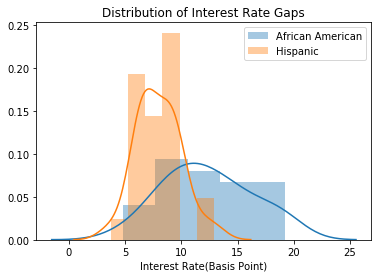

In [26]:
sns.distplot(black["coef"],label="African American");
sns.distplot(hispanic["coef"], label="Hispanic");
plt.legend(); 
plt.title("Distribution of Interest Rate Gaps");
plt.xlabel("Interest Rate(Basis Point)");

In [33]:
black

,Unnamed: 0,Unnamed: 0.1,index,coef,std err,t,P>|t|,[0.025,0.975],r^2,...,hispanic_combined_solar,asian_combined_solar,black_maj_solar,asian_maj_solar,hispanic_maj_solar,final_race_Asian,final_race_Black or African American,final_race_Hispanic or Latino,at_least_one,MSA
1,1,1,final_race_Black or African American,16.5705,2.173,7.626,0.0,12.311,20.83,0.3945122469257465,...,NaN,NaN,0.121338,NaN,NaN,0,1,1,1,26420.0
571,571,1,final_race_Black or African American,11.5914,3.115,3.721,0.0,5.481,17.702,0.41083936554935785,...,NaN,NaN,-0.669197,NaN,NaN,0,1,0,1,34980.0
974,974,1,final_race_Black or African American,18.8083,3.397,5.5360000000000005,0.0,12.145,25.471,0.43979265773353393,...,-0.040627,-0.061289,NaN,-0.000861,-0.047387,0,1,1,1,36740.0
1409,1409,1,final_race_Black or African American,19.1828,4.2410000000000005,4.524,0.0,10.857999999999999,27.508000000000003,0.4428847915845342,...,0.053716,NaN,0.014489,NaN,0.053716,0,1,1,1,48424.0
1742,1742,1,final_race_Black or African American,15.1275,2.138,7.077000000000001,0.0,10.937000000000001,19.317999999999998,0.4306651507846623,...,NaN,NaN,-0.254724,NaN,NaN,0,1,1,1,19124.0
2126,2126,1,final_race_Black or African American,7.3182,3.448,2.123,0.034,0.556,14.08,0.4293668849393101,...,NaN,NaN,NaN,NaN,NaN,0,1,1,1,23104.0
2396,2396,1,final_race_Black or African American,8.5014,2.34,3.633,0.0,3.9130000000000003,13.09,0.36236439881155746,...,-0.090482,0.215445,-0.143908,0.215445,-0.067700,0,1,1,1,16974.0
3677,3677,1,final_race_Black or African American,4.8099,2.27,2.119,0.034,0.36,9.26,0.4045470804584488,...,NaN,NaN,NaN,NaN,NaN,0,1,0,1,33460.0
5076,5076,1,final_race_Black or African American,11.1372,3.2119999999999997,3.467,0.001,4.836,17.438,0.48188152697897113,...,NaN,NaN,NaN,NaN,NaN,0,1,0,1,39580.0
5862,5862,1,final_race_Black or African American,14.3582,3.679,3.903,0.0,7.138,21.578000000000003,0.45283974352827705,...,NaN,NaN,NaN,NaN,NaN,0,1,0,1,35084.0


In [98]:
a=results.loc[results["index"]=="final_race_Asian"]["coef"]
a

0                -3.1445
394      Not Enough Data
485      Not Enough Data
570              -6.9293
807      Not Enough Data
973              -4.9124
1251     Not Enough Data
1408     Not Enough Data
1601     Not Enough Data
1741            -11.8767
2125             -6.5179
2395             -2.2959
2744             -8.0712
2994             -2.2139
3328     Not Enough Data
3464     Not Enough Data
3676             -1.1641
3963     Not Enough Data
4086     Not Enough Data
4211     Not Enough Data
4312     Not Enough Data
4449     Not Enough Data
4576     Not Enough Data
4675             -7.3697
4831     Not Enough Data
4923     Not Enough Data
5075             -4.7261
5303     Not Enough Data
5363             -4.3891
5573     Not Enough Data
              ...       
16879            -4.2886
17008    Not Enough Data
17088    Not Enough Data
17147    Not Enough Data
17236    Not Enough Data
17362    Not Enough Data
17476             2.3761
17712             -2.141
17948    Not Enough Data


In [80]:
results.shape

(20341, 20)

In [32]:
res = Results(failed_msa[3])
#val = res.pipeline()

In [19]:
count

143

C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


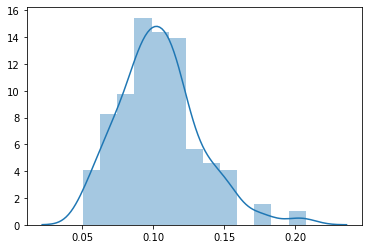

In [32]:
sns.distplot(Results.errors);

In [20]:
len(failed_msa)

260

In [33]:
res.get_data_2018()

In [39]:
failed_msa[3]

'31084'

In [26]:
res.date()

In [45]:
len(av)

393

In [114]:
x=list(pd.get_dummies(res.one[["final_race"]]).columns)

In [123]:
#x.remove('final_race_Race Not Available')
x.remove('final_race_White')
x

['final_race_Asian',
 'final_race_Black or African American',
 'final_race_Hispanic or Latino']

In [124]:
np.where(val["index"]==x[2])[0][0]

2

In [154]:
nc=pd.Series(nc).astype(str).str.replace(' ', '')
nc

Series([], dtype: object)

In [50]:
av.head()

,MSA,credit_score
MSA,,
10180,10180,746.121925
10380,10380,724.777778
10420,10420,731.569730
10500,10500,762.544974
10540,10540,762.322640


In [83]:
def md_MSA(md): 
    if (md==14484) |(md==15764)|(md==37764)|(md==40484):
        return 14460
    elif (md==16974) |(md==23844)|(md==29404): 
        return 16980
    elif (md==19124) |(md==23104): 
        return 19100
    elif (md==19804) |(md==47644):
        return 19820
    elif (md==31084) |(md==42044): 
        return 31100
    elif (md==22744) |(md==33124)|(md==48424):
        return 33100
    elif (md==20764) |(md==35004)|(md==35084)|(md==35644): 
        return 35620
    elif (md==15804) |(md==37964)|(md==48864):
        return 37980
    elif (md==36084) |(md==41884):
        return 41860 
    elif (md==42644) |(md==45104): 
          return 42660 
    elif (md==13644) |(md==47894): 
          return 47900
    
    
        

In [59]:
md_MSA(31084)

31100

In [62]:
av["credit_score"][47900]

761.8075520394997

In [160]:
cont=res.one["county_code"].unique()

In [129]:
cont

array(['08005', '08059', '08014', '08035', '08001', '08039', '08031',
       '08047', '08093', '08019'], dtype=object)

In [36]:
res.get_solar()

In [37]:
res.date()

In [63]:
m=[]
for i in failed_msa:
    try:
        res = Results(i)
        val = res.pipeline()       
    except Exception as e:
        m.append(e)

Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Final Cleaning:Done
Date:Done
g_fee:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


Solar:Done


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done
Data:Done


In [81]:
m[8]

ValueError('Length of values does not match length of index')

In [82]:
failed_msa[8]

'12420'

In [165]:
sum(names["FIPS"]==cont[0])

1

In [166]:
cont=[i for i in cont if sum(names["FIPS"]==cont[0])==1]

In [167]:
cont

['08005',
 '08059',
 '08014',
 '08035',
 '08001',
 '08039',
 '08031',
 '08047',
 '08093',
 '08019']

In [197]:
sum(names["FIPS"]=='12086')

0

In [146]:
names[names["FIPS"]==cont[5]]["county"].reset_index()["county"][0]

' Adams'

In [157]:
nc=[names[names["FIPS"]==i]["county"].reset_index()["county"][0] for i in cont]

In [193]:
res.one["county_code"].unique()[0]

'12086'

In [ ]:
res = Results(failed_msa[52])
val = res.pipeline()

Data:Done
Final Cleaning:Done


In [199]:
val

,index,coef,std err,t,P>|t|,[0.025,0.975],r^2,p,black_combined_solar,hispanic_combined_solar,asian_combined_solar,black_maj_solar,asian_maj_solar,hispanic_maj_solar,final_race_Asian,final_race_Black or African American,final_race_Hispanic or Latino,at_least_one
0,final_race_Asian,-4.6881,1.944,-2.412,0.016,-8.499,-0.878,0.430842,1.589939e-02,NaN,-0.064481,NaN,NaN,NaN,-0.057926,0,1,1,1
1,final_race_Black or African American,7.2379,2.792,2.592,0.010,1.765,12.711,0.430842,9.555537e-03,NaN,-0.064481,NaN,NaN,NaN,-0.057926,0,1,1,1
2,final_race_Hispanic or Latino,6.9478,1.335,5.204,0.000,4.331,9.565,0.430842,2.024158e-07,NaN,-0.064481,NaN,NaN,NaN,-0.057926,0,1,1,1
3,final_race_Race Not Available,0.1661,1.645,0.101,0.920,-3.060,3.392,0.430842,9.195888e-01,NaN,-0.064481,NaN,NaN,NaN,-0.057926,0,1,1,1
4,derived_sex_Female,-0.2029,1.046,-0.194,0.846,-2.253,1.847,0.430842,8.461451e-01,NaN,-0.064481,NaN,NaN,NaN,-0.057926,0,1,1,1
5,derived_sex_Joint,1.7896,0.971,1.844,0.065,-0.113,3.692,0.430842,6.524021e-02,NaN,-0.064481,NaN,NaN,NaN,-0.057926,0,1,1,1
6,derived_sex_Sex Not Available,-0.5109,2.301,-0.222,0.824,-5.023,4.001,0.430842,8.243116e-01,NaN,-0.064481,NaN,NaN,NaN,-0.057926,0,1,1,1
7,applicant_age_25-34,0.7566,1.185,0.638,0.523,-1.567,3.080,0.430842,5.232444e-01,NaN,-0.064481,NaN,NaN,NaN,-0.057926,0,1,1,1
8,applicant_age_35-44,0.4533,1.220,0.371,0.710,-1.939,2.846,0.430842,7.103685e-01,NaN,-0.064481,NaN,NaN,NaN,-0.057926,0,1,1,1
9,applicant_age_55-64,0.5623,1.366,0.412,0.681,-2.115,3.239,0.430842,6.805300e-01,NaN,-0.064481,NaN,NaN,NaN,-0.057926,0,1,1,1


In [127]:
names

,Unnamed: 0,FIPS,Name,county
0,0,02000,AK,NaN
1,1,02013,"AK, Aleutians East",Aleutians East
2,2,02016,"AK, Aleutians West",Aleutians West
3,3,02020,"AK, Anchorage",Anchorage
4,4,02050,"AK, Bethel",Bethel
5,5,02060,"AK, Bristol Bay",Bristol Bay
6,6,02068,"AK, Denali",Denali
7,7,02070,"AK, Dillingham",Dillingham
8,8,02090,"AK, Fairbanks North Star",Fairbanks North Star
9,9,02100,"AK, Haines",Haines


In [38]:
count

118

In [202]:
m[52:]

[ValueError("could not convert string to float: 'Exempt'"),
 KeyError('final_race_Black or African American'),
 KeyError('final_race_Asian'),
 AssertionError(),
 AssertionError(),
 AssertionError(),
 AssertionError(),
 ValueError("Bin edges must be unique: array([71., 80., 95., 95., 97.]).\nYou can drop duplicate edges by setting the 'duplicates' kwarg"),
 ValueError('Length of values does not match length of index'),
 ValueError("Bin edges must be unique: array([55.88   , 80.     , 80.     , 93.07775, 96.977  ]).\nYou can drop duplicate edges by setting the 'duplicates' kwarg"),
 ValueError("Bin edges must be unique: array([30.19, 80.  , 80.  , 95.  , 97.  ]).\nYou can drop duplicate edges by setting the 'duplicates' kwarg"),
 ValueError("Bin edges must be unique: array([74.07  , 88.1425, 95.    , 95.    , 97.    ]).\nYou can drop duplicate edges by setting the 'duplicates' kwarg"),
 AssertionError(),
 KeyError('final_race_Black or African American'),
 KeyError('final_race_Black or Af

In [24]:
conts=res.one["county_code"].unique()

In [25]:
conts

array(['17031', '17043', '17111', '17093', '17197', '17063', 'NA'],
      dtype=object)

In [229]:
nc=[names[names["FIPS"]==i]["county"].reset_index()["county"][0] for i in conts]

In [224]:
conts[6]

'05035'

In [23]:
names

,Unnamed: 0,FIPS,Name,county
0,0,02000,AK,NaN
1,1,02013,"AK, Aleutians East",Aleutians East
2,2,02016,"AK, Aleutians West",Aleutians West
3,3,02020,"AK, Anchorage",Anchorage
4,4,02050,"AK, Bethel",Bethel
5,5,02060,"AK, Bristol Bay",Bristol Bay
6,6,02068,"AK, Denali",Denali
7,7,02070,"AK, Dillingham",Dillingham
8,8,02090,"AK, Fairbanks North Star",Fairbanks North Star
9,9,02100,"AK, Haines",Haines


In [191]:
res.get_data_2018()

In [188]:
res.get_solar()

C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:280: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in double_scalars


In [158]:
res.error.head()

,Unnamed: 0.1,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,...,rebate,avg_electricity_retail_rate,fp,Unnamed: 0,id,Asian%_tract,Black or African American%_tract,Hispanic or Latino (of any race)%_tract,White%_tract,Majority
0,70707,8.0,5.0,180.050235,049045130600,51885.400517,Tooele,125,264,7,...,0,8.32,49045130600,66499,49045130600,1.2,2.1,55.9,46.5,Majority Hispanic
1,70708,35.0,30.0,1341.682672,049045130702,90767.647793,Tooele,1864,3142,100,...,0,8.32,49045130702,66501,49045130702,1.0,0.6,8.9,93.7,Majority White
2,70709,7.0,7.0,188.425220,049045130703,79609.345372,Tooele,602,1806,18,...,0,8.32,49045130703,66502,49045130703,1.1,0.0,6.9,95.5,Majority White
3,70710,5.0,5.0,76.055793,049045131002,63676.474926,Tooele,670,1916,0,...,0,8.32,49045131002,66506,49045131002,0.0,0.5,15.7,82.2,Majority White
4,70712,4.0,3.0,91.540625,049045130701,84085.714286,Tooele,406,577,12,...,0,8.32,49045130701,66500,49045130701,0.2,0.1,8.9,95.3,Majority White


In [160]:
sum(hr["id"]=="49045130600")

1

In [141]:
res.error

,Unnamed: 0.1,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,...,rebate,avg_electricity_retail_rate,fp,Unnamed: 0,id,Asian%_tract,Black or African American%_tract,Hispanic or Latino (of any race)%_tract,White%_tract,Majority
0,70707,8.0,5.0,180.050235,049045130600,51885.400517,Tooele,125,264,7,...,0,8.32,49045130600,66499,49045130600,1.2,2.1,55.9,46.5,Majority Hispanic
1,70708,35.0,30.0,1341.682672,049045130702,90767.647793,Tooele,1864,3142,100,...,0,8.32,49045130702,66501,49045130702,1.0,0.6,8.9,93.7,Majority White
2,70709,7.0,7.0,188.425220,049045130703,79609.345372,Tooele,602,1806,18,...,0,8.32,49045130703,66502,49045130703,1.1,0.0,6.9,95.5,Majority White
3,70710,5.0,5.0,76.055793,049045131002,63676.474926,Tooele,670,1916,0,...,0,8.32,49045131002,66506,49045131002,0.0,0.5,15.7,82.2,Majority White
4,70712,4.0,3.0,91.540625,049045130701,84085.714286,Tooele,406,577,12,...,0,8.32,49045130701,66500,49045130701,0.2,0.1,8.9,95.3,Majority White
5,70713,15.0,12.0,501.543107,049045130800,61063.914550,Tooele,556,1122,26,...,0,8.32,49045130800,66503,49045130800,2.1,0.8,5.1,92.3,Majority White
6,70714,4.0,4.0,57.848022,049045130900,59553.978358,Tooele,320,1025,6,...,0,8.32,49045130900,66504,49045130900,0.1,0.0,21.9,84.5,Majority White
7,70715,3.0,3.0,76.877323,049045131001,79678.997290,Tooele,170,615,6,...,0,8.32,49045131001,66505,49045131001,1.6,0.0,12.1,88.2,Majority White
8,70716,10.0,7.0,174.828839,049045131100,64412.664908,Tooele,798,1800,19,...,0,8.32,49045131100,66507,49045131100,0.2,1.0,12.5,90.3,Majority White
9,70717,4.0,4.0,97.422747,049045131200,67403.885135,Tooele,335,903,0,...,0,8.32,49045131200,66508,49045131200,0.8,0.7,9.4,94.0,Majority White


In [106]:
res.error1.head()

,Unnamed: 0.1,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,70707,8.0,5.0,180.050235,049045130600,51885.400517,Tooele,125,264,7,...,26,7,11,15,0,16,0,0,0,8.32
1,70708,35.0,30.0,1341.682672,049045130702,90767.647793,Tooele,1864,3142,100,...,26,7,11,15,0,16,0,0,0,8.32
2,70709,7.0,7.0,188.425220,049045130703,79609.345372,Tooele,602,1806,18,...,26,7,11,15,0,16,0,0,0,8.32
3,70710,5.0,5.0,76.055793,049045131002,63676.474926,Tooele,670,1916,0,...,26,7,11,15,0,16,0,0,0,8.32
4,70711,0.0,0.0,0.000000,049045980000,NaN,Tooele,0,0,0,...,26,7,11,15,0,16,0,0,0,8.32


In [113]:
sum(census["id"]=="49045130600")

1

In [123]:
res.error["fips"]

Series([], Name: fips, dtype: object)

In [132]:
res.error1["fp"]=res.error1["fips"].str.slice(start=1)

In [114]:
len(str(49045130600))

11

In [74]:
pickle_model.features

AttributeError: 'RandomForestRegressor' object has no attribute 'features'

In [77]:
res.error.columns

Index(['bin_lv_below 25th percentile',
       'bin_lv_between 25th percentile and 50th percentile',
       'bin_lv_between 50th percentile and 75th percentile',
       'bin_lv_greater than 75th percentile', 'debt_to_income_ratio_20%-<30%',
       'debt_to_income_ratio_30%-<36%', 'debt_to_income_ratio_36%-<41%',
       'debt_to_income_ratio_41%-<46%', 'debt_to_income_ratio_46%-<50%',
       'debt_to_income_ratio_50%-60%', 'debt_to_income_ratio_<20%',
       'debt_to_income_ratio_>60%', 'total_units_1', 'total_units_2',
       'av_credit'],
      dtype='object')

In [68]:
res.one["total_units"].value_counts()

1    573
2      3
Name: total_units, dtype: int64

In [54]:
val

,index,coef,std err,t,P>|t|,[0.025,0.975],r^2,p,black_combined_solar,hispanic_combined_solar,asian_combined_solar,black_maj_solar,asian_maj_solar,hispanic_maj_solar,final_race_Asian,final_race_Black or African American,final_race_Hispanic or Latino,at_least_one
0,final_race_Asian,-2.8542,2.389,-1.195,0.232,-7.540,1.831,0.326963,2.323973e-01,0.075761,NaN,NaN,0.112115,NaN,NaN,0,1,1,1
1,final_race_Black or African American,6.8348,2.941,2.324,0.020,1.068,12.602,0.326963,2.020568e-02,0.075761,NaN,NaN,0.112115,NaN,NaN,0,1,1,1
2,final_race_Hispanic or Latino,6.6470,1.823,3.645,0.000,3.071,10.223,0.326963,2.730702e-04,0.075761,NaN,NaN,0.112115,NaN,NaN,0,1,1,1
3,final_race_Race Not Available,0.9571,2.819,0.339,0.734,-4.572,6.486,0.326963,7.342905e-01,0.075761,NaN,NaN,0.112115,NaN,NaN,0,1,1,1
4,derived_sex_Female,0.7365,1.761,0.418,0.676,-2.716,4.189,0.326963,6.757535e-01,0.075761,NaN,NaN,0.112115,NaN,NaN,0,1,1,1
5,derived_sex_Joint,2.1446,1.556,1.378,0.168,-0.906,5.196,0.326963,1.681996e-01,0.075761,NaN,NaN,0.112115,NaN,NaN,0,1,1,1
6,derived_sex_Sex Not Available,-4.9158,3.747,-1.312,0.190,-12.264,2.433,0.326963,1.897073e-01,0.075761,NaN,NaN,0.112115,NaN,NaN,0,1,1,1
7,applicant_age_25-34,-5.7103,1.944,-2.937,0.003,-9.523,-1.898,0.326963,3.345579e-03,0.075761,NaN,NaN,0.112115,NaN,NaN,0,1,1,1
8,applicant_age_35-44,-2.7672,2.000,-1.384,0.167,-6.689,1.154,0.326963,1.665595e-01,0.075761,NaN,NaN,0.112115,NaN,NaN,0,1,1,1
9,applicant_age_55-64,-1.3527,2.519,-0.537,0.591,-6.293,3.588,0.326963,5.913703e-01,0.075761,NaN,NaN,0.112115,NaN,NaN,0,1,1,1


In [84]:
res.get_data_2018()

In [63]:
Results.errors

[]

In [22]:
res.one["county_code"].unique()

array(['48157', '48201', '48473', '48167', '48039', '48339', '48015',
       '48071', '48291'], dtype=object)

In [27]:
sum(names["FIPS"]=='048157')

1

In [ ]:
2.323973e-0

In [126]:
res.final_cleaning()

In [127]:
res.g_fee()

In [116]:
res.error.columns

Index(['index', 'coef', 'std err', 't', 'P>|t|', '[0.025', '0.975]', 'r^2',
       'black_combined_solar', 'hispanic_combined_solar',
       'asian_combined_solar', 'black_maj_solar', 'asian_maj_solar',
       'hispanic_maj_solar', 'final_race_Asian',
       'final_race_Black or African American',
       'final_race_Hispanic or Latino'],
      dtype='object')

In [55]:
res.one["final_race"].value_counts()

White                        203
Asian                        168
Race Not Available            72
Hispanic or Latino            66
Black or African American     18
Name: final_race, dtype: int64

In [125]:
res.get_data_2018()

In [67]:
hr["id"]=hr["id"].astype(str)
house["id"]=house["id"].astype(str)
mo["id"]=mo["id"].astype(str)

Unnamed: 0                            int64
id                                    int64
Estimate!!Total!!Owner occupied       int64
Estimate!!Total!!Renter occupied      int64
Geographic Area Name                 object
ratio                               float64
dtype: object

In [58]:
res.get_solar()

C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:240: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:242: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:246: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:248: RuntimeWarning: invalid value encountered in double_scalars


In [61]:
res.error["Majority"].value_counts()

Majority White    9
Majority Black    6
whiteblack        2
Name: Majority, dtype: int64

In [78]:
filtered=res.error.merge(hr[["id","ratio"]], left_on="fips",right_on="id")

In [79]:
filtered=filtered.merge(mo[["id","mratio"]], left_on="fips",right_on="id")
filtered=filtered.merge(house[['id','Estimate!!Total!!HOUSEHOLDS!!Total households']], left_on="fips",right_on="id")

In [80]:
filtered

,Unnamed: 0.1,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,...,Black or African American%_tract,Hispanic or Latino (of any race)%_tract,White%_tract,Majority,id_y,ratio,id_x,mratio,id_y,Estimate!!Total!!HOUSEHOLDS!!Total households
0,22835,108.0,89.0,2035.838260,06001442400,119109.409969,Alameda,873,1333,75,...,3.4,23.9,29.1,No Majority,06001442400,1.768878,06001442400,0.686377,06001442400,2016
1,22836,32.0,26.0,605.412743,06001437600,70079.035874,Alameda,256,686,11,...,8.8,44.0,34.4,hispanicwhite,06001437600,1.619645,06001437600,0.704415,06001437600,914
2,22837,85.0,67.0,2442.808845,06001438000,88930.291628,Alameda,664,703,58,...,4.2,36.9,49.1,No Majority,06001438000,1.407429,06001438000,0.833803,06001438000,1144
3,22838,175.0,137.0,4648.216168,06001438100,96955.167464,Alameda,767,1405,24,...,7.4,38.2,32.6,hispanicwhite,06001438100,1.980676,06001438100,0.773448,06001438100,2158
4,22839,177.0,150.0,4642.632173,06001400100,238370.839813,Alameda,756,368,214,...,4.1,3.3,68.1,Majority White,06001400100,8.215976,06001400100,0.615717,06001400100,1297
5,22840,63.0,53.0,1316.230729,06001400200,181039.663462,Alameda,615,188,82,...,2.9,8.8,76.6,Majority White,06001400200,1.831625,06001400200,0.740602,06001400200,855
6,22841,107.0,97.0,1866.740011,06001400300,132724.668542,Alameda,1507,662,212,...,7.6,7.3,75.1,Majority White,06001400300,1.081376,06001400300,0.768212,06001400300,2441
7,22842,102.0,86.0,1896.043787,06001400400,118158.856191,Alameda,980,444,313,...,6.0,10.9,70.3,Majority White,06001400400,0.723840,06001400400,0.748851,06001400400,1750
8,22843,68.0,58.0,1420.750149,06001400500,81218.596059,Alameda,1130,671,80,...,26.1,8.8,53.8,Majority White,06001400500,0.706943,06001400500,0.776860,06001400500,1622
9,22844,29.0,25.0,469.905843,06001400600,87526.961484,Alameda,395,256,77,...,22.0,7.6,54.0,Majority White,06001400600,0.870264,06001400600,0.710247,06001400600,657


In [76]:
sum(house["id"]=="6001442400")

1

In [54]:
res.one["county_code"].unique()

array(['06013', '06001'], dtype=object)

In [52]:
res.g_fee()

In [74]:
names["FIPS"]=["0"+i for i in names["FIPS"]]
nc=[names[names["FIPS"]==i]["county"].reset_index()["county"][0] for i in cont]

IndexError: index out of bounds

In [79]:
names[names["FIPS"]=='06001']["county"].reset_index()

,index,county


In [75]:
names

,Unnamed: 0,FIPS,Name,county
0,0,0002000,AK,NaN
1,1,0002013,"AK, Aleutians East",Aleutians East
2,2,0002016,"AK, Aleutians West",Aleutians West
3,3,0002020,"AK, Anchorage",Anchorage
4,4,0002050,"AK, Bethel",Bethel
5,5,0002060,"AK, Bristol Bay",Bristol Bay
6,6,0002068,"AK, Denali",Denali
7,7,0002070,"AK, Dillingham",Dillingham
8,8,0002090,"AK, Fairbanks North Star",Fairbanks North Star
9,9,0002100,"AK, Haines",Haines


In [28]:
res.one

,derived_msa-md,final_race,applicant_age,debt_to_income_ratio,Cost_of_Loan,derived_sex,loan_to_value_ratio,rate_spread,tract_minority_population_percent,ffiec_msa_md_median_family_income,...,purchaser_type,prepayment_penalty_term,discount_points,lender_credits,origination_charges,cost,bin_income,bin_lv,interest_basis_points,discount
106,36084,Asian,35-44,36%-<41%,4841.2,Joint,75.000,1.165,73.1400000000000006,104400,...,Freddie Mac,NA,0.00,7.98,0.164662,4833.22,greater than 75th percentile,between 25th percentile and 50th percentile,575.0,-0.001200
254,36084,Race Not Available,65-74,41%-<46%,5542.04,Sex Not Available,75.000,0.198,39.8800000000000026,104400,...,Fannie Mae,NA,0.00,0.00,0.653495,5542.04,greater than 75th percentile,between 25th percentile and 50th percentile,475.0,0.000000
202,36084,White,<25,41%-<46%,4726.5,Male,95.000,0.657,98.7999999999999972,104400,...,Freddie Mac,NA,0.00,1448.75,0.246783,3277.75,between 25th percentile and 50th percentile,greater than 75th percentile,412.5,-0.251957
217,36084,White,55-64,41%-<46%,7550.36,Joint,60.000,0.126,39.5799999999999983,104400,...,Fannie Mae,NA,1503.36,0.00,0.387343,9053.72,between 50th percentile and 75th percentile,below 25th percentile,500.0,0.233079
182,36084,White,65-74,41%-<46%,8582.0,Joint,61.650,0.752,74.019999999999996,104400,...,Freddie Mac,NA,2265.50,0.00,0.882747,10847.50,greater than 75th percentile,below 25th percentile,550.0,0.497912
78,36084,Asian,25-34,41%-<46%,3919.87,Joint,77.419,0.768,62.5200000000000031,104400,...,Fannie Mae,NA,0.00,3532.80,0.205155,387.07,between 25th percentile and 50th percentile,between 25th percentile and 50th percentile,475.0,-0.728412
22,36084,Black or African American,55-64,30%-<36%,4310.0,Male,90.000,0.912,80.6099999999999994,104400,...,Fannie Mae,NA,0.00,0.00,0.239683,4310.00,between 50th percentile and 75th percentile,greater than 75th percentile,531.3,0.000000
140,36084,White,45-54,46%-<50%,5117.62,Joint,77.509,0.463,34.1400000000000006,104400,...,Fannie Mae,NA,421.12,0.00,0.424072,5538.74,greater than 75th percentile,between 25th percentile and 50th percentile,525.0,0.094634
60,36084,White,35-44,41%-<46%,16307.45,Joint,78.121,0.407,71.8499999999999943,104400,...,Freddie Mac,NA,0.00,4862.15,1.672556,11445.30,greater than 75th percentile,between 25th percentile and 50th percentile,487.5,-0.720319
475,36084,Asian,55-64,20%-<30%,8412.18,Joint,89.990,0.509,37.9699999999999989,104400,...,Freddie Mac,NA,3432.23,75.00,0.669960,11769.41,greater than 75th percentile,between 50th percentile and 75th percentile,500.0,0.497367


In [23]:
res.final_cleaning()

In [24]:
res.one.shape

(2815, 46)

In [ ]:
res.

In [49]:
res.date()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [57]:
res.one["Cost_of_Loan"]

0             0.0
1          7003.8
2         7781.75
3        15816.69
4          3647.5
5         8285.05
6         5066.09
7         4424.74
8         4130.03
9         4345.04
10        4451.44
11        3480.02
12        4032.89
13        4210.19
14        3767.46
15        3894.45
16         4620.9
17        4176.84
18        7635.75
19        7369.26
20         3433.3
21        6444.17
22        4686.63
23        4644.49
24        4669.45
25        5931.14
26        4162.82
27         4798.5
28       12971.14
29        6018.14
           ...   
39362      5236.6
39363     6315.59
39364     4952.07
39365     9914.56
39366      9783.9
39367      8599.4
39368     6036.75
39369     4208.28
39370     4888.55
39371     4300.64
39372    10257.98
39373      5071.3
39374     8232.67
39375     5200.71
39376      3165.6
39377     9054.87
39378     5329.95
39379    11662.45
39380    12688.57
39381    16608.02
39382     7195.64
39383       550.0
39384         0.0
39385         0.0
39386     

In [40]:
res.one.columns

Index(['derived_msa-md', 'final_race', 'applicant_age', 'debt_to_income_ratio',
       'Cost_of_Loan', 'derived_sex', 'loan_to_value_ratio', 'rate_spread',
       'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'lei', 'state_code', 'county_code',
       'census_tract', 'loan_amount', 'hoepa_status', 'property_value',
       'total_units', 'aus', 'tract_to_msa_income_percentage',
       'open-end_line_of_credit', 'tract_owner_occupied_units',
       'tract_one_to_four_family_homes', 'tract_median_age_of_housing_units',
       'income', 'Asian%_tract', 'Black or African American%_tract',
       'Hispanic or Latino (of any race)%_tract', 'White%_tract',
       'interest_rate', 'loan_term', 'intro_rate_period',
       'interest_only_payment', 'balloon_payment', 'negative_amortization',
       'other_nonamortizing_features', 'purchaser_type',
       'prepayment_penalty_term', 'discount_points', 'lender_credits',
       'origination_charges', 'bin_income', 'b

In [12]:
g_fee.dtypes

credit              object
< 60.00%           float64
60.01 –  70.00%    float64
70.01 – 75.00%     float64
75.01 – 80.00%     float64
80.01 – 85.00%     float64
85.01 – 90.00%     float64
90.01 – 95.00%     float64
95.01 – 97.00%     float64
>97.00%            float64
dtype: object